In [1]:
!git clone https://github.com/WMARBAR/Mundial_Inferences.git

Cloning into 'Mundial_Inferences'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 71 (delta 26), reused 48 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 5.19 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
import sys
sys.path.append('/content/Mundial_Inferences')  # Asegúrate que esta ruta es correcta

# 5. MODELOS

# LIBS

In [3]:
# ==========================================
# Análisis completo de jugadores mundialistas
# Basado en confederación y condición de campeón
# ==========================================


from exps.loaders import Loaders
from exps.mundial_exps_extended import Experimentos
from exps.dists import AnalisisEstadistico
from exps.dists import Muestreos
import pandas as pd
import scipy.stats as stats
ld=Loaders()
exper=Experimentos()
muestreos= Muestreos()


# Cargar archivo Excel
path = '/content/Mundial_Inferences/datain/Proyecto_mundial.xlsx'
df_mundial= ld.cargar_excel(path,'Sheet1')

# Inicializar clases
dist = AnalisisEstadistico(df_mundial)
exper = Experimentos()


# Regresión Lineal Simple: Edad vs Goles

In [4]:
import statsmodels.api as sm

X = df_mundial['edad_enMundial']
y = df_mundial['Goles Marcados(mundial)']
X = sm.add_constant(X)
modelo_simple = sm.OLS(y, X).fit()
print(modelo_simple.summary())


                               OLS Regression Results                              
Dep. Variable:     Goles Marcados(mundial)   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     2.105
Date:                     Wed, 04 Jun 2025   Prob (F-statistic):              0.147
Time:                             05:57:34   Log-Likelihood:                -10277.
No. Observations:                     9296   AIC:                         2.056e+04
Df Residuals:                         9294   BIC:                         2.057e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Regresión Lineal Múltiple

In [5]:
X_multi = df_mundial[['edad_enMundial', 'Partidos Jugados']]
y = df_mundial['Goles Marcados(mundial)']
X_multi = sm.add_constant(X_multi)
modelo_multi = sm.OLS(y, X_multi).fit()
print(modelo_multi.summary())


                               OLS Regression Results                              
Dep. Variable:     Goles Marcados(mundial)   R-squared:                       0.083
Model:                                 OLS   Adj. R-squared:                  0.082
Method:                      Least Squares   F-statistic:                     418.0
Date:                     Wed, 04 Jun 2025   Prob (F-statistic):          1.47e-174
Time:                             05:57:34   Log-Likelihood:                -9877.5
No. Observations:                     9296   AIC:                         1.976e+04
Df Residuals:                         9293   BIC:                         1.978e+04
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# Regresión Logística: ¿Fue Campeón?

In [6]:
from statsmodels.api import Logit

X_log = df_mundial[['edad_enMundial', 'Partidos Jugados']]
y_log = df_mundial['dummy_campeon']
X_log = sm.add_constant(X_log)
modelo_log = Logit(y_log, X_log).fit()
print(modelo_log.summary())


Optimization terminated successfully.
         Current function value: 0.180852
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          dummy_campeon   No. Observations:                 9296
Model:                          Logit   Df Residuals:                     9293
Method:                           MLE   Df Model:                            2
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.05427
Time:                        05:57:34   Log-Likelihood:                -1681.2
converged:                       True   LL-Null:                       -1777.7
Covariance Type:            nonrobust   LLR p-value:                 1.273e-42
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.2479      0.324    -10.027      0.000      -3.883      -2.613
edad_enMund

# ANALISIS DE RESIDUOS

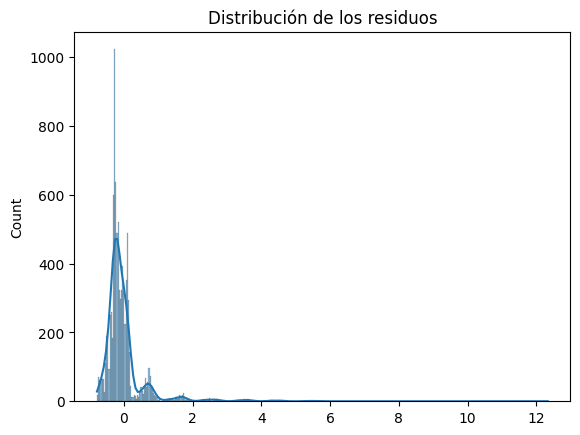

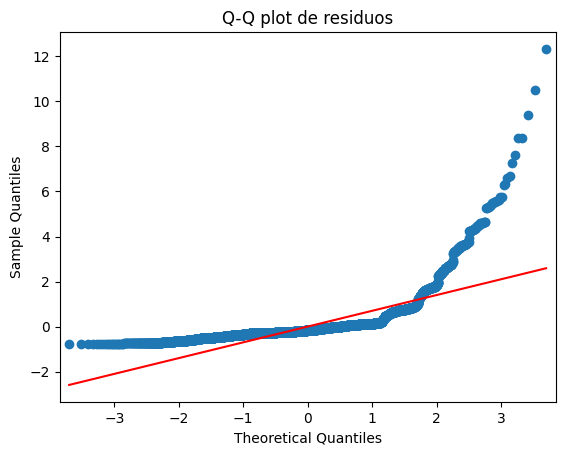

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

residuos = modelo_multi.resid
sns.histplot(residuos, kde=True)
plt.title("Distribución de los residuos")
plt.show()

sm.qqplot(residuos, line='s')
plt.title("Q-Q plot de residuos")
plt.show()


# Métricas de evaluación

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = modelo_multi.predict(X_multi)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("MSE:", mse)
print("R²:", r2)


MSE: 0.4902810193043503
R²: 0.08253744658896645


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_log = modelo_log.predict(X_log) > 0.5
print("Accuracy:", accuracy_score(y_log, y_pred_log))
print("Matriz de confusión:\n", confusion_matrix(y_log, y_pred_log))


Accuracy: 0.9524526678141136
Matriz de confusión:
 [[8854    0]
 [ 442    0]]


# PRONOSTICOS

In [10]:
df_equipos = df_mundial.groupby(['MYEAR', 'SIG_SLECCCION']).agg({
    'edad_enMundial': 'mean',
    'Partidos Jugados': 'mean',
    'Goles Marcados(mundial)': 'sum',
    'Grupo_De_La_Muerte': 'mean',
    'dummy_campeon': 'max',
    'confederacion': 'first'
}).reset_index()


In [11]:
df_encoded = pd.get_dummies(df_equipos, columns=['confederacion'], drop_first=True)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['MYEAR', 'SIG_SLECCCION', 'dummy_campeon'])
y = df_encoded['dummy_campeon']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)


LogisticRegression(max_iter=1000)

In [13]:

# Cargar archivo Excel
path = './datain/Mundial_2026.xlsx'
df_2026= ld.cargar_excel(path,'Sheet1')


Error al leer el archivo: [Errno 2] No such file or directory: './datain/Mundial_2026.xlsx'


In [14]:
df_2026_encoded = pd.get_dummies(df_2026, columns=['confederacion'], drop_first=True)

# Asegúrate de alinear columnas
df_2026_encoded = df_2026_encoded.reindex(columns=X.columns, fill_value=0)

probs = model.predict_proba(df_2026_encoded)[:,1]
df_2026['prob_campeon'] = probs

df_2026.sort_values(by='prob_campeon', ascending=False, inplace=True)
print(df_2026[['SIG_SLECCCION', 'prob_campeon']])


TypeError: object of type 'NoneType' has no len()